In [1]:
import numpy as np 
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt 
from numba import njit
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
fs = 44100 
fc = 2000
k_data = 500
k_coeff = 128
N_taps = 8

[ 2  7 21 32 32 21  7  2]
[ 1  6 21 35 35 21  6  1]


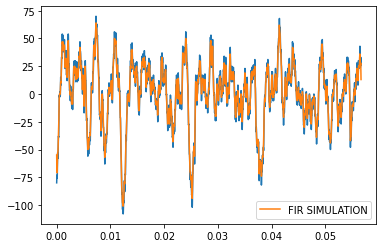

In [3]:
B = np.loadtxt("BET.txt", delimiter=",")
t = B[:2500,0] # take the first 2500
x = B[:2500,1] # input double
xc = x + 0.01*np.sin(2*np.pi*7000*t) # input corr double
xc_int = (k_data*xc).astype(int) # input corr int (rescaled)

coeffs2000 = firwin(numtaps=N_taps, cutoff=2000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs2000 = (k_coeff*coeffs2000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int
coeffs4000 = firwin(numtaps=N_taps, cutoff=4000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs4000 = (k_coeff*coeffs4000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int
print(coeffs2000)
print(coeffs4000)

def fir(input, coeffs, Nt) :
    output = np.zeros(input.shape[0])
    for n in range(7, len(output)) :
        for i in range(Nt) :
            output[n] += int(coeffs[i]*input[n-i])
    return output

xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim2000 = fir(xc_int_wb, coeffs2000, N_taps) # output sim double
output_sim2000 = output_sim2000[7+4:] # we discard the first 7 values and shift by 4
output_sim2000 /= k_coeff
output_sim_int2000 = output_sim2000.astype(int) # output sim int

output_sim4000 = fir(xc_int_wb, coeffs4000, N_taps) # output sim double
output_sim4000 = output_sim4000[7+4:] # we discard the first 7 values and shift by 4
output_sim4000 /= k_coeff
output_sim_int4000 = output_sim4000.astype(int) # output sim int

plt.plot(t,xc_int, label="",zorder=1)
plt.plot(t,output_sim_int2000,label="FIR SIMULATION",zorder=2)
plt.legend()

Text(0.5, 1.0, 'Audio signal in time domain')

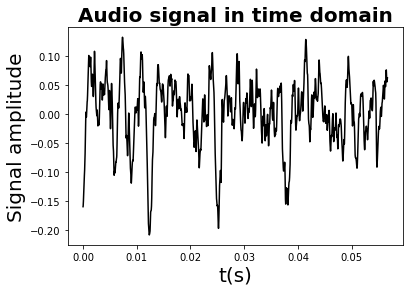

In [4]:
t = B[:2500,0] # take the first 2500
x = B[:2500,1] # input doubl

plt.plot(t,x, color="black")
plt.xlabel("t(s)", fontsize="20")
plt.ylabel("Signal amplitude",fontsize="20")
plt.title("Audio signal in time domain", fontsize=20, fontweight="bold")

In [5]:
def frequency_spectrum(t, x, fs = None) :
    if fs is None :
        fs = 1/(np.diff(t).mean())
    a = np.abs(np.fft.fft(x))*2/len(x)
    a = a[0:len(a)//2]
    f = np.linspace(0,fs//2,len(a))
    return [f,a]

(0.0, 8000.0)

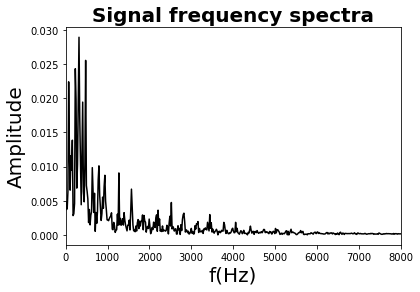

In [6]:
[f,ac] = frequency_spectrum(t, xc_int, fs = fs)
[_,ax] = frequency_spectrum(t, output_sim_int2000, fs = fs)
[_,ao] = frequency_spectrum(t, output_sim_int4000, fs = fs)


#plt.plot(*frequency_spectrum(t,xc,fs=fs), label = "segnale corrotto")
plt.plot(*frequency_spectrum(t,x,fs=fs), color="black")
#plt.scatter(*frequency_spectrum(t,x,fs=fs), label = "segnale puro", color="black", s=55)
#plt.plot(*frequency_spectrum(t,output_sim_int2000, fs = fs), label = "Python filtered")
#plt.plot(*frequency_spectrum(t,output_fpga,fs=fs), label ="FPGA filtered")
#plt.plot(f,ao,label="FILTER SIM 4000")

plt.xlabel("f(Hz)", fontsize=20)
plt.title("Signal frequency spectra", fontsize=20, fontweight="bold")
plt.ylabel("Amplitude",fontsize=20)
#plt.xscale('log')
plt.xlim(0,8000)


(2500,)


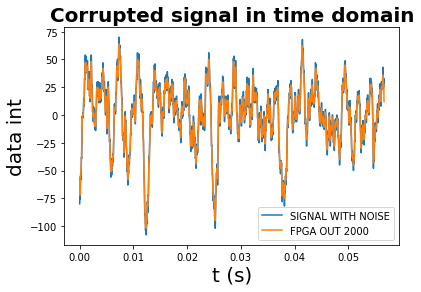

In [7]:
output_fpga = np.loadtxt("output_results.txt")
output_fpga = output_fpga[4:]

print(output_fpga.shape)
plt.plot(t,xc_int, label = 'SIGNAL WITH NOISE')
plt.plot(t,output_fpga, label = 'FPGA OUT 2000')
plt.xlabel("t (s)",fontsize="20")
plt.ylabel("data int",fontsize="20")
plt.title("Corrupted signal in time domain", fontsize="20",fontweight="bold");
plt.legend()
#plt.xlim(0,0.02)

/home/eleonora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


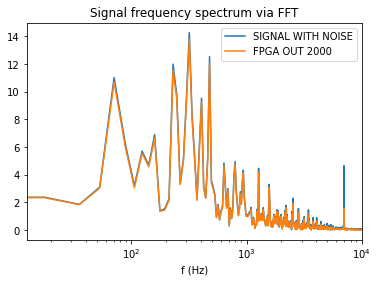

In [8]:
plt.plot(*frequency_spectrum(t,xc_int,fs=fs), label = 'SIGNAL WITH NOISE')
plt.plot(*frequency_spectrum(t,output_fpga,fs=fs),  label = 'FPGA OUT 2000')
plt.xscale('log')
plt.xlabel("f (Hz)")
plt.title("Signal frequency spectrum via FFT");
plt.xlim(0,10000)
plt.legend(loc="upper right")

0.0
-1.0


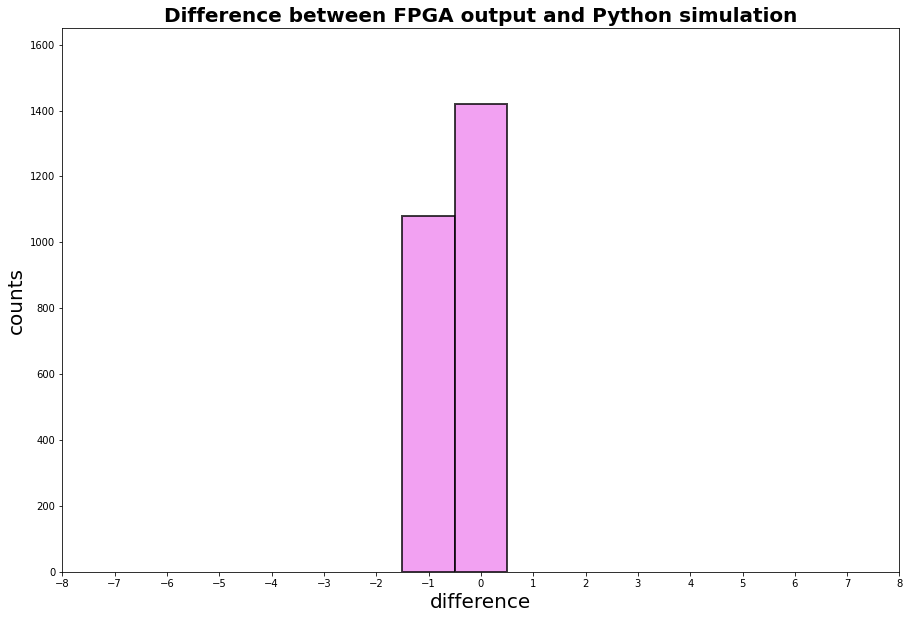

In [38]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
difference = output_fpga - output_sim_int2000
print(max(difference))
print(min(difference))
ax.hist(difference, bins = [ -1.5, -0.5, 0.5 ], alpha = 0.75, color ="violet", edgecolor="black",linewidth=2)
plt.ylabel("counts", fontsize=20)
plt.xlabel("difference", fontsize=20)
plt.title("Difference between FPGA output and Python simulation", fontweight="bold", fontsize=20)
plt.xlim(-8,8)
plt.ylim(0,1650)
ax.xaxis.set_major_locator(MultipleLocator(1)) #every tick on x axes is an integer

0.0
-1.0


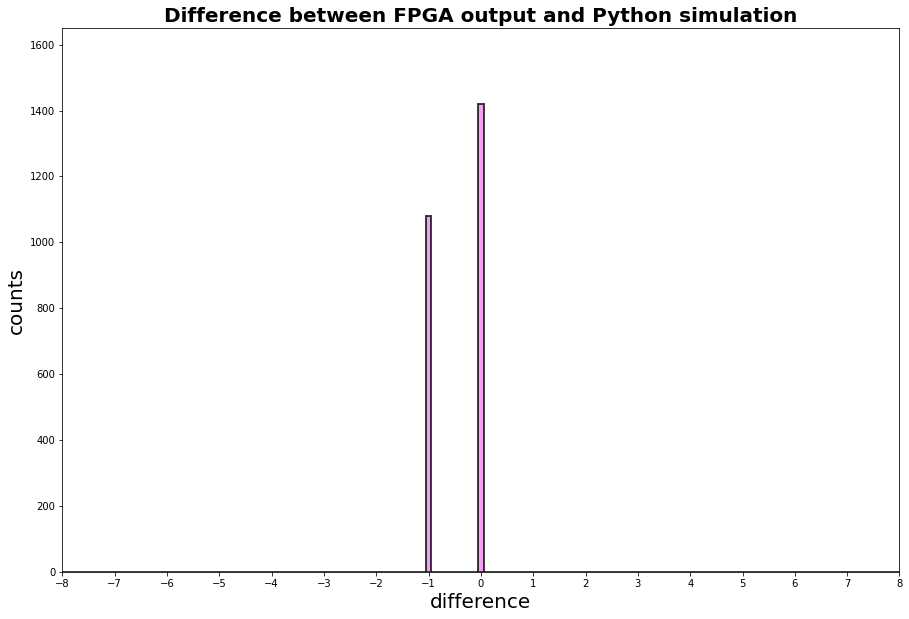

In [39]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
difference = output_fpga - output_sim_int2000
print(max(difference))
print(min(difference))
ax.hist(difference, bins = list(np.linspace(-8,8,160)), alpha = 0.75, color ="violet", edgecolor="black",linewidth=2)
plt.ylabel("counts", fontsize=20)
plt.xlabel("difference", fontsize=20)
plt.title("Difference between FPGA output and Python simulation", fontweight="bold", fontsize=20)
plt.xlim(-8,8)
plt.ylim(0,1650)
ax.xaxis.set_major_locator(MultipleLocator(1)) #every tick on x axes is an integer

(<matplotlib.patches.Rectangle at 0x7f07aa244290>,
 (<matplotlib.patches.ConnectionPatch at 0x7f07aa2bcdd0>,
  <matplotlib.patches.ConnectionPatch at 0x7f07aa1f9210>))

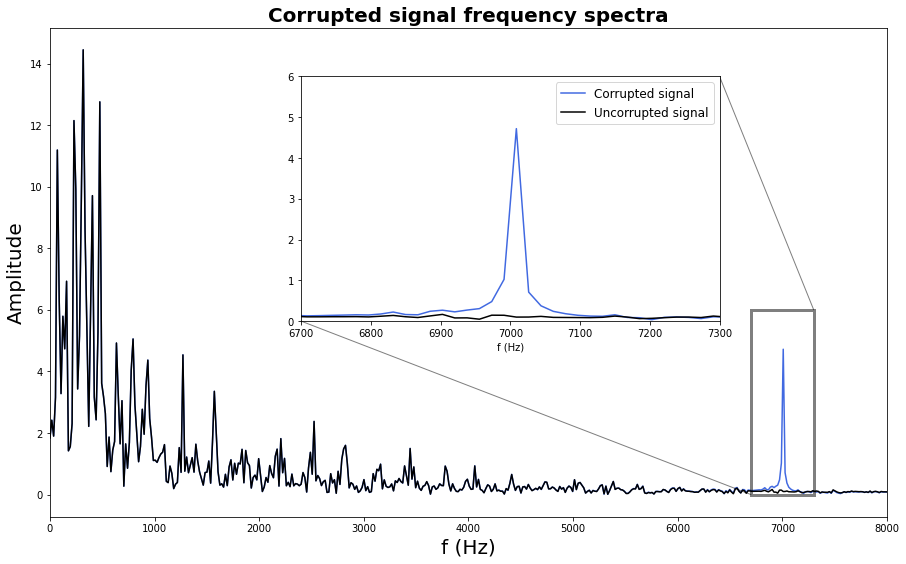

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))

ax.plot(*frequency_spectrum(t,500*xc,fs=fs), label = "Corrupted signal", color = "royalblue")
ax.plot(*frequency_spectrum(t,500*x,fs=fs), label = "Uncorrupted signal", color = "black")
#ax.plot(*frequency_spectrum(t,output_sim_int2000, fs = fs), label = "FIR Python simulation", color ="crimson")
#ax.plot(*frequency_spectrum(t,output_fpga,fs=fs), label ="FPGA output", color = "violet")
#plt.plot(f,ao,label="FILTER SIM 4000")


ax.set_xlabel("f (Hz)",fontsize="20")
ax.set_title("Corrupted signal frequency spectra", fontweight="bold", fontsize=20)
#plt.xscale('log')
#plt.legend(loc = "best")
plt.xlim(0,8000)
plt.ylabel("Amplitude",fontsize="20")




axins = ax.inset_axes([0.3,0.4,0.5,0.5])

axins.plot(*frequency_spectrum(t,500*xc,fs=fs), label = "Corrupted signal", color = "royalblue")
axins.plot(*frequency_spectrum(t,500*x,fs=fs), label = "Uncorrupted signal", color = "black")
#axins.plot(*frequency_spectrum(t,output_sim_int2000, fs = fs), label = "FIR Python simulation", color ="crimson")
#axins.plot(*frequency_spectrum(t,output_fpga,fs=fs), label ="FPGA output", color = "violet")

axins.set_ylim(0, 6)
axins.set_xlim(6700, 7300)

axins.set_xlabel("f (Hz)")
#axins.set_title("Signals frequency spectra", fontweight="bold", fontsize=20)
#ax.legend(loc="best",fontsize=10)
axins.legend(loc="best",fontsize=12)
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=3)


### praticamente si vede come il segnale di Python sia uguale a quello dell' FPGA (cosa buona e giusta)

In [12]:
coeffs10000 = firwin(numtaps=N_taps, cutoff=10000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
print(coeffs10000)
coeffs10000 = (k_coeff*coeffs10000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int

coeffs5000 = firwin(numtaps=N_taps, cutoff=5000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs5000 = (k_coeff*coeffs5000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int

coeffs2000 = firwin(numtaps=N_taps, cutoff=2000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs2000 = (k_coeff*coeffs2000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int

coeffs500 = firwin(numtaps=N_taps, cutoff=500, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs500 = (k_coeff*coeffs500).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int

print(coeffs10000)
print(coeffs5000)
print(coeffs2000)
print(coeffs500)

[-0.00711711 -0.01336718  0.11689263  0.40359166  0.40359166  0.11689263
 -0.01336718 -0.00711711]
[ 0 -1 14 51 51 14 -1  0]
[ 0  5 20 36 36 20  5  0]
[ 2  7 21 32 32 21  7  2]
[ 2  8 21 31 31 21  8  2]


In [13]:
def fir(input, coeffs, Nt) :
    output = np.zeros(input.shape[0])
    for n in range(7, len(output)) :
        for i in range(Nt) :
            output[n] += int(coeffs[i]*input[n-i])
    return output

In [14]:
xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim10000 = fir(xc_int_wb, coeffs10000, N_taps) # output sim double
output_sim10000 = output_sim10000[7+4:] # we discard the first 7 values and shift by 4
output_sim10000 /= k_coeff
output_sim_int10000 = output_sim10000.astype(int) # output sim int


In [15]:
xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim5000 = fir(xc_int_wb, coeffs5000, N_taps) # output sim double
output_sim5000 = output_sim5000[7+4:] # we discard the first 7 values and shift by 4
output_sim5000 /= k_coeff
output_sim_int5000 = output_sim5000.astype(int) # output sim int

In [16]:
xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim2000 = fir(xc_int_wb, coeffs2000, N_taps) # output sim double
output_sim2000 = output_sim2000[7+4:] # we discard the first 7 values and shift by 4
output_sim2000 /= k_coeff
output_sim_int2000 = output_sim2000.astype(int) # output sim int

In [17]:
xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim500 = fir(xc_int_wb, coeffs500, N_taps) # output sim double
output_sim500 = output_sim500[7+4:] # we discard the first 7 values and shift by 4
output_sim500 /= k_coeff
output_sim_int500 = output_sim500.astype(int) # output sim int

(<matplotlib.patches.Rectangle at 0x7f07a85f7850>,
 (<matplotlib.patches.ConnectionPatch at 0x7f07a85c1f50>,
  <matplotlib.patches.ConnectionPatch at 0x7f07a85f7050>))

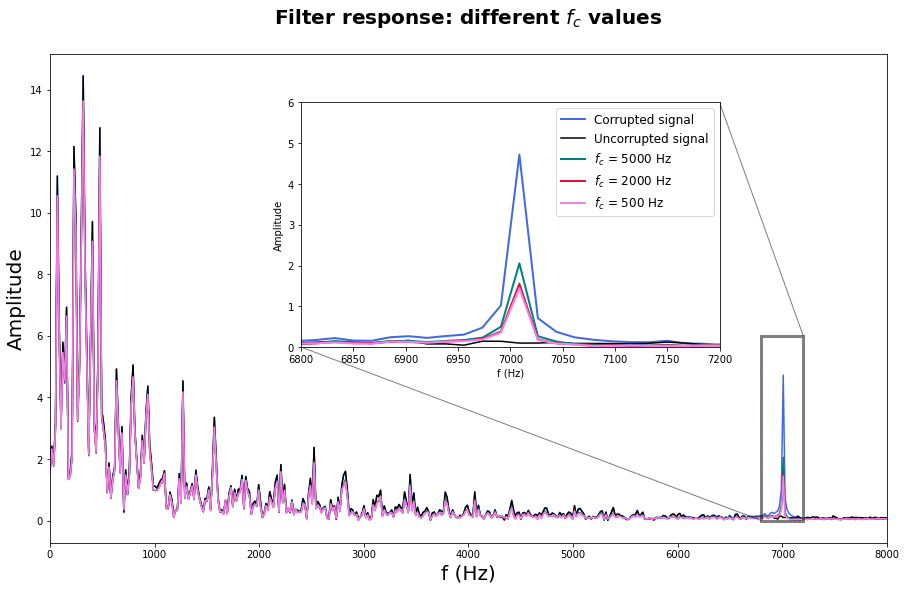

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))

ax.plot(*frequency_spectrum(t,500*xc,fs=fs), label = "segnale corrotto", color ="royalblue")
#plt.plot(*frequency_spectrum(t,output_sim_int10000, fs = fs), label = "fc = 10000")
ax.plot(*frequency_spectrum(t,500*x,fs=fs), label = "segnale puro", color = "black")
ax.plot(*frequency_spectrum(t,output_sim_int5000, fs = fs), label = "fc = 5000",color ="teal")
ax.plot(*frequency_spectrum(t,output_sim_int2000, fs = fs), label = "fc = 2000", color ="crimson")
ax.plot(*frequency_spectrum(t,output_sim_int500, fs = fs), label = "fc = 500",color ="violet")

ax.set_title("Filter response: different $f_c$ values \n", fontweight="bold", fontsize="20")
#plt.legend(loc = "best")

plt.xlabel("f (Hz)",fontsize="20")
plt.ylabel("Amplitude",fontsize="20")
plt.xlim(0, 8000)


axins = ax.inset_axes([0.3,0.4,0.5,0.5])
axins.plot(*frequency_spectrum(t,500*xc,fs=fs), label = "Corrupted signal", color ="royalblue",linewidth=2)
#plt.plot(*frequency_spectrum(t,output_sim_int10000, fs = fs), label = "fc = 10000")
axins.plot(*frequency_spectrum(t,500*x,fs=fs), label = "Uncorrupted signal", color = "black")
axins.plot(*frequency_spectrum(t,output_sim_int5000, fs = fs), label = "$f_c$ = 5000 Hz", color ="teal",linewidth=2)
axins.plot(*frequency_spectrum(t,output_sim_int2000, fs = fs), label = "$f_c$ = 2000 Hz", color ="crimson",linewidth=2)
axins.plot(*frequency_spectrum(t,output_sim_int500, fs = fs), label = "$f_c$ = 500 Hz", color ="violet",linewidth=2)

axins.set_ylim(0, 6)
axins.set_xlim(6800, 7200)
axins.set_ylabel("Amplitude")

axins.set_xlabel("f (Hz)")
#axins.set_title("Signals frequency spectra", fontweight="bold", fontsize=20)
#ax.legend(loc="best",fontsize=10)
axins.legend(loc="best",fontsize=12)
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=3)
#ax.grid()
#axins.grid()

In [19]:
def frequency_spectrum(t, x, fs = None) :
    if fs is None :
        fs = 1/(np.diff(t).mean())
    a = np.abs(np.fft.fft(x))*2/len(x)
    a = a[0:len(a)//2]
    f = np.linspace(0,fs//2,len(a))
    return [f,a]

In [20]:
for i in f:
    if i < 8000 and i > 6000:
        print(i)

6002.40192153723
6020.056044835868
6037.7101681345075
6055.364291433147
6073.018414731785
6090.672538030424
6108.326661329063
6125.980784627702
6143.634907926341
6161.28903122498
6178.943154523619
6196.597277822258
6214.251401120897
6231.905524419536
6249.559647718174
6267.213771016814
6284.867894315453
6302.522017614091
6320.17614091273
6337.8302642113695
6355.484387510008
6373.138510808647
6390.792634107286
6408.4467574059245
6426.100880704564
6443.755004003203
6461.409127301841
6479.06325060048
6496.71737389912
6514.371497197758
6532.025620496397
6549.679743795036
6567.333867093675
6584.987990392314
6602.642113690953
6620.296236989591
6637.9503602882305
6655.60448358687
6673.258606885508
6690.912730184147
6708.566853482786
6726.220976781425
6743.875100080064
6761.529223378703
6779.183346677342
6796.837469975981
6814.49159327462
6832.145716573259
6849.799839871897
6867.453963170537
6885.108086469176
6902.762209767814
6920.416333066453
6938.0704563650925
6955.724579663731
6973.3787029

In [21]:
import math

In [22]:
f[396]

6991.032826261009

In [23]:
[f_corr, a_corr] = frequency_spectrum(t,500*xc,fs=fs)

In [24]:
a_corr[397]

4.720720559384499

In [25]:
[f2000, a2000] = frequency_spectrum(t,output_sim_int2000, fs = fs)

In [26]:
a2000[397]

1.5562276478996484

In [27]:
a2000[398]/a_corr[398] *100

26.67128111825608

In [28]:
coeffs50 = firwin(numtaps=N_taps, cutoff=50, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR

coeffs50 = (k_coeff*coeffs50).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int


(0.0, 8000.0)

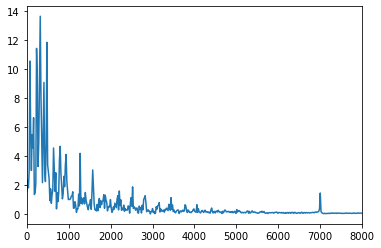

In [29]:
xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim50 = fir(xc_int_wb, coeffs50, N_taps) # output sim double
output_sim50 = output_sim50[7+4:] # we discard the first 7 values and shift by 4
output_sim50 /= k_coeff
output_sim_int50 = output_sim50.astype(int) # output sim int
plt.plot(*frequency_spectrum(t,output_sim_int50, fs = fs), label = "fc = 500")
plt.xlim(0, 8000)

# PYTHON CODE TO INCLUDE IN THE REPORT 

Text(0.5, 1.0, 'Comparison of results')

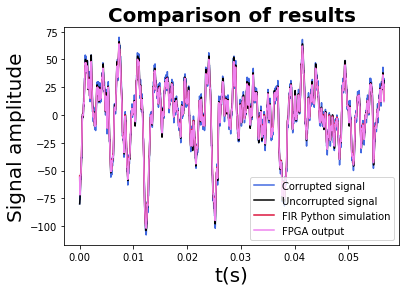

In [30]:
k_data = 500
k_coeff = 128

fs = 44100
fc = 2000 
N_taps = 8
N = N_taps

coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
#coeffs = (k_coeff*coeffs)
coeffs = (k_coeff*coeffs).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int

#print(np.abs((k_data*xc).astype(int)).max()) #i dati sono moltiplicati per un coefficiente. Qui vediamo il massimo 



def fir(input, coeffs, Nt) :
    output = np.zeros(input.shape[0])
    for n in range(7, len(output)) :
        for i in range(Nt) :
            output[n] += int(coeffs[i]*input[n-i])
    return output

xc_int_wb = np.concatenate((np.zeros(7), xc_int,np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim2000 = fir(xc_int_wb, coeffs2000, N_taps) # output sim double
output_sim2000 = output_sim2000[7+4:] # we discard the first 7 values and shift by 4
output_sim2000 /= k_coeff
output_sim_int2000 = output_sim2000.astype(int) # output sim int



#plt.plot(t,(k_data*x).astype(int),label="SIGNAL WITHOUT NOISE", color="black")
plt.plot(t,xc_int, label="Corrupted signal", color="royalblue")
plt.plot(t,(k_data*x).astype(int),label="Uncorrupted signal", color="black")
plt.plot(t,output_sim_int2000,label="FIR Python simulation", color="crimson")
plt.plot(t,output_fpga,label="FPGA output", color ="violet")
plt.xlabel("t(s)", fontsize=20)
plt.ylabel("Signal amplitude", fontsize=20)
plt.legend(loc="best")

plt.title("Comparison of results", fontweight="bold", fontsize=20)

Text(0.5, 1.0, 'Corrupted and uncorrupted signals in time domain')

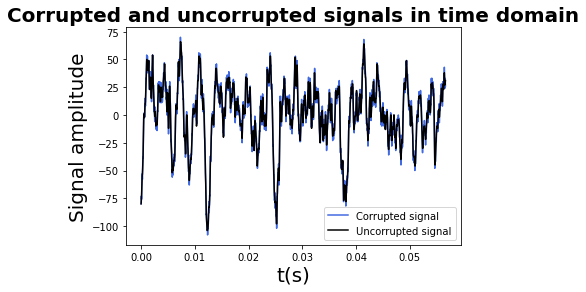

In [31]:
plt.plot(t,xc_int, label="Corrupted signal", color="royalblue")
plt.plot(t,(k_data*x).astype(int),label="Uncorrupted signal", color="black")
plt.legend(loc="best")
plt.xlabel("t(s)", fontsize=20)
plt.ylabel("Signal amplitude", fontsize=20)
plt.title("Corrupted and uncorrupted signals in time domain", fontsize=20, fontweight="bold")

In [32]:
import math
def func(x):
    if x >0:
        x = math.floor(x)
    if x <0:
        x = np.abs(x)
        x = - math.ceil(x)
    return x

In [33]:
k_data = 500
k_coeff = 128

fs = 44100
fc = 2000 
N_taps = 8
N = N_taps

coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass") #compute filter coefficients
#coeffs = (k_coeff*coeffs)
coeffs = (k_coeff*coeffs).astype(int) #FIR coefficients multiplication by k_coeff and integer conversion 


#Filter convolution
def fir(input, coeffs, Nt) :
    output = np.zeros(input.shape[0])
    for n in range(7, len(output)) :
        for i in range(Nt) :
            output[n] += int(coeffs[i]*input[n-i])
    return output

xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim2000 = fir(xc_int_wb, coeffs, N_taps) # output (double)
output_sim2000 = output_sim2000[7+4:] #discard the first 7 values and shift by 4
#output_sim2000 = output_sim2000 >> 7
"""ldc = []
for i in output_sim2000:
    ldc.append(bin(int(i)))

ldc  = np.asarray(ldc) >> 7
print(bin(int(output_sim2000[0]))[2:9])
y = bin(int(output_sim2000[0]))[2:9]
print(np.int8(y))"""

#print(output_sim2000[0])
#print(bin(int(output_sim2000[0])))
#print(output_sim2000[0]+255)
#print(bin(int(output_sim2000[0]+255)))
output_sim2000 /= k_coeff
cz = []
for i in output_sim2000:
    cz.append(func(i))

output_sim_int2000 = output_sim2000.astype(int) # output (int)


In [34]:
tuple(zip(output_sim2000, output_sim_int2000, cz,  output_fpga))

((-55.9609375, -55, -56, -56.0),
 (-67.5625, -67, -68, -68.0),
 (-70.921875, -70, -71, -71.0),
 (-71.3046875, -71, -72, -72.0),
 (-69.328125, -69, -70, -70.0),
 (-65.484375, -65, -66, -66.0),
 (-60.5078125, -60, -61, -61.0),
 (-56.171875, -56, -57, -57.0),
 (-53.8046875, -53, -54, -54.0),
 (-53.28125, -53, -54, -54.0),
 (-52.984375, -52, -53, -53.0),
 (-51.2421875, -51, -52, -52.0),
 (-47.65625, -47, -48, -48.0),
 (-43.3671875, -43, -44, -44.0),
 (-39.8671875, -39, -40, -40.0),
 (-37.4140625, -37, -38, -38.0),
 (-34.7265625, -34, -35, -35.0),
 (-30.2265625, -30, -31, -31.0),
 (-23.53125, -23, -24, -24.0),
 (-15.8671875, -15, -16, -16.0),
 (-9.1796875, -9, -10, -10.0),
 (-4.8203125, -4, -5, -5.0),
 (-2.6484375, -2, -3, -3.0),
 (-1.59375, -1, -2, -2.0),
 (-0.65625, 0, -1, -1.0),
 (0.2890625, 0, 0, 0.0),
 (0.71875, 0, 0, 0.0),
 (0.4765625, 0, 0, 0.0),
 (0.1640625, 0, 0, 0.0),
 (0.8828125, 0, 0, 0.0),
 (3.28125, 3, 3, 3.0),
 (6.7890625, 6, 6, 6.0),
 (9.8203125, 9, 9, 9.0),
 (11.109375, 11,

In [35]:
def confronto(lista1, lista2, lista3):
    lista1 = np.asarray(lista1)
    lista2 = np.asarray(lista2)
    count = 0
    for i in range(len(lista1)):
        if lista1[i] == lista2[i]:
            count+=1
        else:
            print(lista1[i], lista2[i], lista3[i], i)
            
    if count == len(lista1):
        print("Tutti gli elementi sono uguali")
        
    else:
        print("NON tutti gli elementi sono uguali")
        
            

In [36]:
confronto(cz, output_fpga, output_sim2000)

21 20.0 21.3515625 2498
13 12.0 13.5625 2499
NON tutti gli elementi sono uguali


In [37]:
print(int(output_sim2000[0]))

-55
